## TPE Tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge

from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

import optuna

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import dataset
load_dotenv()
# Load X and y splits
x_train_path = os.getenv("X_TRAIN_MERGED_SCALED")
x_test_path  = os.getenv("X_TEST_MERGED_SCALED")
y_train_path = os.getenv("Y_TRAIN_MERGED_SCALED")
y_test_path  = os.getenv("Y_TEST_MERGED_SCALED")

X_train = pd.read_csv(x_train_path)
X_test  = pd.read_csv(x_test_path)
y_train = pd.read_csv(y_train_path)
y_test  = pd.read_csv(y_test_path)

# Optional: quick check
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(875, 23) (875, 1)
(376, 23) (376, 1)


In [3]:
imputer_nonLin = IterativeImputer(
    estimator=BayesianRidge(),
    random_state=42,
)

imputer_nonLin.fit(X_train)
X_train_knn = imputer_nonLin.transform(X_train)
X_test_knn = imputer_nonLin.transform(X_test)

In [4]:
X_train_knn_t = pd.DataFrame(
    X_train_knn, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_knn_t = pd.DataFrame(
    X_test_knn, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [5]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_knn_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [6]:
X_train_t = pipe.transform(X_train_knn_t)
X_test_t = pipe.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((875, 23), (376, 23))

In [7]:
sel = ['RID', 'Gender', 'Ageatscreening', 'MMSE0m', 'HipsASMbaseline',
       'HipsContrastbaseline', 'HipsCorelationbaseline',
       'HipsSumAveragebaseline', 'HipsSumVariancebaseline',
       'HipsEntropybaseline', 'ERCsASMbaseline', 'ERCsContrastbaseline',
       'ERCsVariancebaseline', 'ERCsSumVariancebaseline',
       'ERCsEntropybaseline', 'ERCsClusterShadebaseline',
       'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'HipposcampusVolumebaseline']

In [8]:
selected_features = [col for col in sel if col in X_train_t.columns]
selected_features

['RID',
 'Gender',
 'Ageatscreening',
 'MMSE0m',
 'HipsASMbaseline',
 'HipsContrastbaseline',
 'HipsCorelationbaseline',
 'HipsSumAveragebaseline',
 'HipsSumVariancebaseline',
 'HipsEntropybaseline',
 'ERCsASMbaseline',
 'ERCsContrastbaseline',
 'ERCsVariancebaseline',
 'ERCsSumVariancebaseline',
 'ERCsEntropybaseline',
 'ERCsClusterShadebaseline',
 'ERCs_thicknessbaseline',
 'ERCsVolumebaseline',
 'HipposcampusVolumebaseline']

In [9]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((875, 19), (376, 19))

## TPE

In [10]:
def objective(trial):
        
    skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
            
    xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 100, 500)
    xgb_max_depth = trial.suggest_int("xgb_max_depth", 2, 5)
    xgb_learning_rate = trial.suggest_float("xgb_learning_rate", 0.01, 0.2)
    xgb_subsample = trial.suggest_float("xgb_subsample", 0.5, 1.0)
    xgb_colsample_bytree = trial.suggest_float("xgb_colsample_bytree", 0.6, 1.0)
    xgb_min_child_weight = trial.suggest_int("xgb_min_child_weight", 1, 6)
    xgb_gamma = trial.suggest_float("xgb_gamma", 0.0, 2.0)

    model = XGBClassifier(
        n_estimators=xgb_n_estimators,
        max_depth=xgb_max_depth,
        learning_rate=xgb_learning_rate,
        subsample=xgb_subsample,
        colsample_bytree=xgb_colsample_bytree,
        min_child_weight=xgb_min_child_weight,
        gamma=xgb_gamma,
        objective="multi:softprob",
        num_class=len(set(y_train))
    )

    score = cross_val_score(model, X_train_t, y_train, scoring="balanced_accuracy", cv=skf)
    
    accuracy = score.mean()
    
    return accuracy

In [11]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)

study.optimize(objective, n_trials=20)

[I 2025-11-15 23:11:31,019] A new study created in memory with name: no-name-64cd409a-9b11-4094-80f6-ee76cff14ac5
[I 2025-11-15 23:11:44,333] Trial 0 finished with value: 0.7155365479525143 and parameters: {'xgb_n_estimators': 353, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.018052483401397527, 'xgb_subsample': 0.5629151691661476, 'xgb_colsample_bytree': 0.9511507208743526, 'xgb_min_child_weight': 6, 'xgb_gamma': 1.830136404851107}. Best is trial 0 with value: 0.7155365479525143.
[I 2025-11-15 23:11:56,552] Trial 1 finished with value: 0.7280721288515407 and parameters: {'xgb_n_estimators': 439, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.19400750313360438, 'xgb_subsample': 0.9826849213976352, 'xgb_colsample_bytree': 0.7029491762793771, 'xgb_min_child_weight': 3, 'xgb_gamma': 0.5619217678019586}. Best is trial 1 with value: 0.7280721288515407.
[I 2025-11-15 23:12:09,870] Trial 2 finished with value: 0.7333309990662932 and parameters: {'xgb_n_estimators': 231, 'xgb_max_depth': 5, 'xgb_lea

In [12]:
study.best_params

{'xgb_n_estimators': 231,
 'xgb_max_depth': 5,
 'xgb_learning_rate': 0.09532235169754527,
 'xgb_subsample': 0.6888100025759161,
 'xgb_colsample_bytree': 0.9085888249754321,
 'xgb_min_child_weight': 1,
 'xgb_gamma': 0.43397877913695293}

In [13]:
study.best_value

0.7333309990662932

In [14]:
r = study.trials_dataframe()
r.head()

,number,value,datetime_start,datetime_complete,duration,params_xgb_colsample_bytree,params_xgb_gamma,params_xgb_learning_rate,params_xgb_max_depth,params_xgb_min_child_weight,params_xgb_n_estimators,params_xgb_subsample,state
0,0,0.715537,2025-11-15 23:11:31.021133,2025-11-15 23:11:44.332237,0 days 00:00:13.311104,0.951151,1.830136,0.018052,4,6,353,0.562915,COMPLETE
1,1,0.728072,2025-11-15 23:11:44.335237,2025-11-15 23:11:56.552900,0 days 00:00:12.217663,0.702949,0.561922,0.194008,4,3,439,0.982685,COMPLETE
2,2,0.733331,2025-11-15 23:11:56.554897,2025-11-15 23:12:09.868819,0 days 00:00:13.313922,0.908589,0.433979,0.095322,5,1,231,0.688810,COMPLETE
3,3,0.706629,2025-11-15 23:12:09.871819,2025-11-15 23:12:14.302690,0 days 00:00:04.430871,0.956503,0.890713,0.177150,2,2,152,0.552707,COMPLETE
4,4,0.722953,2025-11-15 23:12:14.305686,2025-11-15 23:12:21.988768,0 days 00:00:07.683082,0.942229,0.645250,0.160468,4,3,312,0.963868,COMPLETE


C:\Users\steve\AppData\Local\Temp\ipykernel_21696\2278197192.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


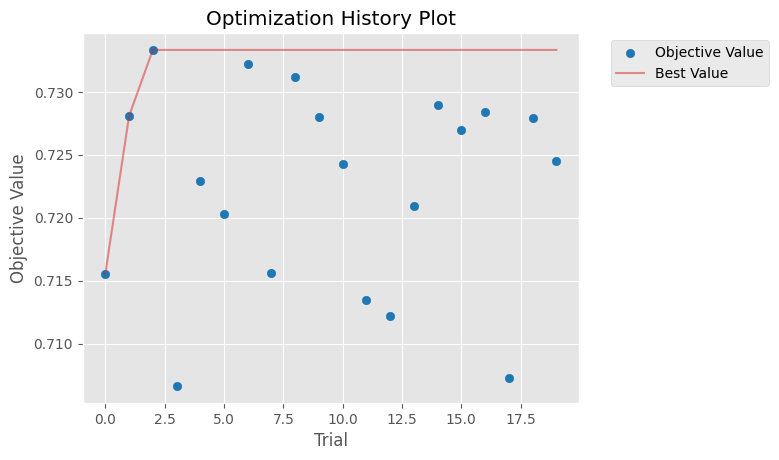

In [15]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_21696\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

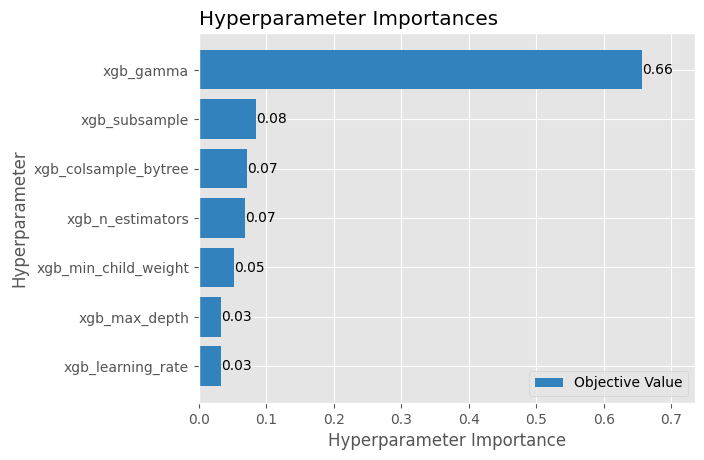

In [16]:
optuna.visualization.matplotlib.plot_param_importances(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_21696\1403512554.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(


array([<Axes: xlabel='xgb_colsample_bytree', ylabel='Objective Value'>,
       <Axes: xlabel='xgb_gamma'>, <Axes: xlabel='xgb_learning_rate'>,
       <Axes: xlabel='xgb_max_depth'>,
       <Axes: xlabel='xgb_min_child_weight'>,
       <Axes: xlabel='xgb_n_estimators'>, <Axes: xlabel='xgb_subsample'>],
      dtype=object)

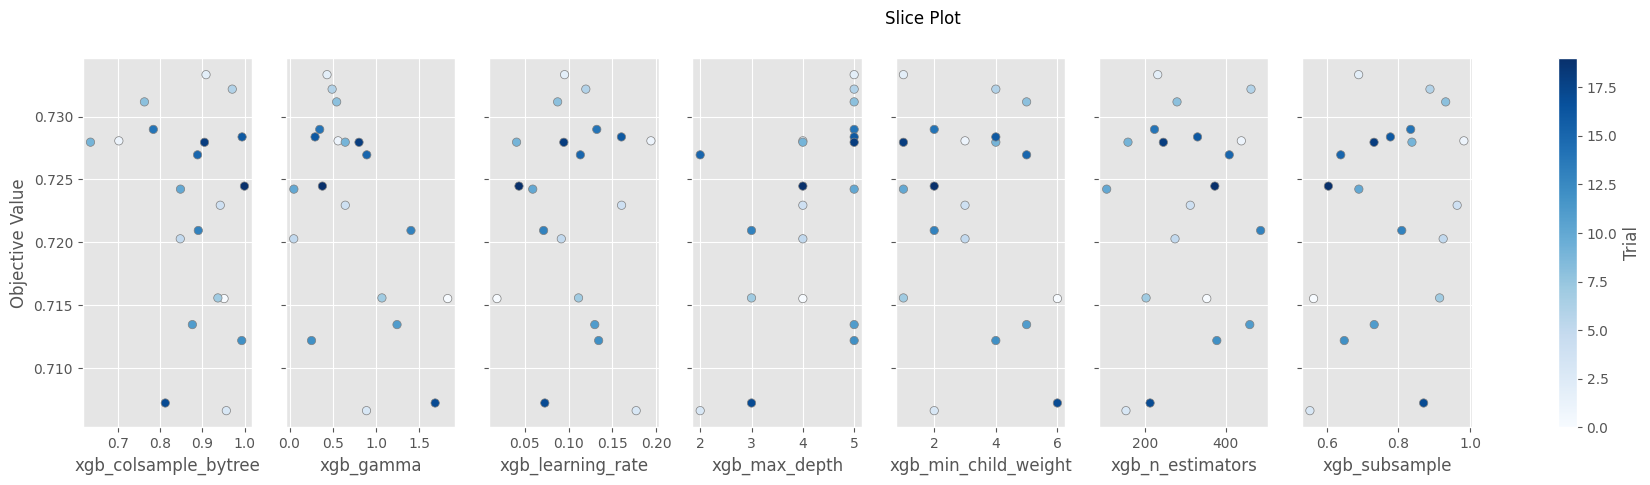

In [17]:
optuna.visualization.matplotlib.plot_slice(
    study,
    params=["xgb_n_estimators", "xgb_max_depth", "xgb_learning_rate", 
            'xgb_subsample', 'xgb_colsample_bytree', 'xgb_min_child_weight',
            'xgb_gamma'],
)

C:\Users\steve\AppData\Local\Temp\ipykernel_21696\2601326980.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf([study])


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

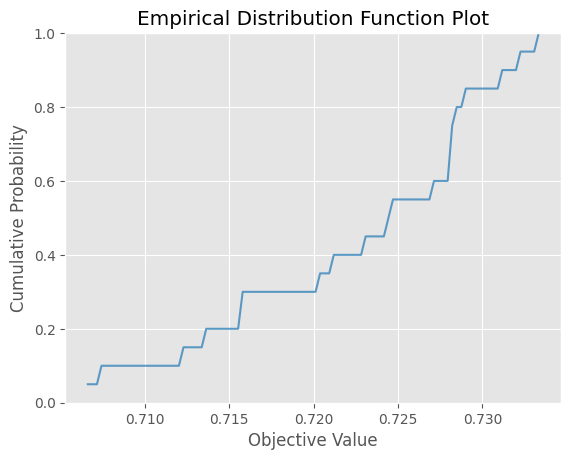

In [18]:
optuna.visualization.matplotlib.plot_edf([study])

## Classification

In [19]:
def run_model(classifier_name, sel_method, X_train, y_train):
        
        model = XGBClassifier(
                n_estimators=study.best_params["xgb_n_estimators"],
                max_depth=study.best_params["xgb_max_depth"],
                learning_rate=study.best_params["xgb_learning_rate"],
                subsample=study.best_params["xgb_subsample"],
                colsample_bytree=study.best_params["xgb_colsample_bytree"],
                min_child_weight=study.best_params["xgb_min_child_weight"],
                gamma=study.best_params["xgb_gamma"],
                objective="multi:softprob",
                num_class=len(set(y_train))
        )

        if sel_method == "Boruta":
                sel_method = "Boruta" 
        else: 
                sel_method = "Complete"
        
        skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=skf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": sel_method,
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": len(X_train.columns),
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [ ]:
trained_xgb_n, metrics_xgb_n = run_model("XGBoost", "Complete", X_train_knn_t, y_train)
trained_xgb_t, metrics_xgb_t = run_model("XGBoost", "Boruta", X_train_t, y_train)

In [23]:
validation_df = pd.concat([metrics_xgb_n, metrics_xgb_t])
validation_df_report = validation_df.set_index(["Classifier", "Metric", "Feature Selection", "Fit Time", "Total Features"])
validation_df_report

Mean Train  \
Classifier Metric            Feature Selection Fit Time Total Features               
XGBoost    balanced_accuracy Complete          2.137    23                   0.999   
                             Boruta            1.387    19                   0.999   

                                                                        Std Train  \
Classifier Metric            Feature Selection Fit Time Total Features              
XGBoost    balanced_accuracy Complete          2.137    23                  0.001   
                             Boruta            1.387    19                  0.001   

                                                                        Mean Test  \
Classifier Metric            Feature Selection Fit Time Total Features              
XGBoost    balanced_accuracy Complete          2.137    23                  0.718   
                             Boruta            1.387    19                  0.733   

                                                                        Std Test  
Classifier Metric            Feature Selection Fit Time Total Features            
XGBoost    balanced_accuracy Complete          2.137    23                 0.050  
                             Boruta            1.387    19                 0.044

In [24]:
from sklearn.utils import resample

def bootstrap_ci(model, X, y, metric_fn, n_iterations, ci=0.95, use_proba=False):
    scores = []
    n = len(X)
    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X, y, n_samples=n, stratify=y)
        try:
            y_pred = model.predict_proba(X_resampled) if use_proba else model.predict(X_resampled)
            score = metric_fn(y_resampled, y_pred)
            if not np.isnan(score):
                scores.append(score)
        except Exception:
            # Skip this bootstrap sample if error occurs (e.g. missing class for roc_auc)
            continue
    if len(scores) == 0:
        return (np.nan, np.nan)
    lower = np.percentile(scores, (1 - ci) / 2 * 100)
    upper = np.percentile(scores, (1 + ci) / 2 * 100)
    std_dev = np.std(scores)
    return round(lower, 3), round(upper, 3), round(std_dev, 3)

In [25]:
from sklearn.metrics import confusion_matrix

def compute_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = total - (tp + fp + fn)
    specificity = tn / (tn + fp)
    return round(np.nanmean(specificity), 3)

In [26]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        if isinstance(X_train, np.ndarray):
                columns = X_train.shape[1]
        else:
                columns = len(X_train.columns)        
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        # Calculate metrics
        metrics_train = {
                "accuracy": accuracy_score(y_train, pred_train),
                "balanced_accuracy": balanced_accuracy_score(y_train, pred_train),
                "precision_macro": precision_score(y_train, pred_train, average="macro", zero_division=0),
                "recall_macro": recall_score(y_train, pred_train, average="macro", zero_division=0),
                "f1_macro": f1_score(y_train, pred_train, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_train, pred_train_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_train, pred_train),
        }

        metrics_test = {
                "accuracy": accuracy_score(y_test, pred_test),
                "balanced_accuracy": balanced_accuracy_score(y_test, pred_test),
                "precision_macro": precision_score(y_test, pred_test, average="macro", zero_division=0),
                "recall_macro": recall_score(y_test, pred_test, average="macro", zero_division=0),
                "f1_macro": f1_score(y_test, pred_test, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_test, pred_test_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_test, pred_test),
        }
                
        elapsed_time = time.time() - start_time
        
        # Metric functions for bootstrap CI (exclude ROC AUC here)
        metric_fns = {
                "accuracy": accuracy_score,
                "balanced_accuracy": balanced_accuracy_score,
                "precision_macro": lambda yt, yp: precision_score(yt, yp, average="macro", zero_division=0),
                "recall_macro": lambda yt, yp: recall_score(yt, yp, average="macro", zero_division=0),
                "f1_macro": lambda yt, yp: f1_score(yt, yp, average="macro", zero_division=0),
                "roc_auc_macro": lambda yt, yp: roc_auc_score(yt, yp, average="macro", multi_class="ovr"),
                "specificity_macro": lambda yt, yp: compute_specificity(yt, yp),
        }

        # Bootstrap confidence intervals
        ci_test = {
                m: bootstrap_ci(
                model, X_test, y_test, fn,
                n_iterations=1000,
                use_proba=(m == "roc_auc_macro")
                )
                for m, fn in metric_fns.items()
        }

        # Separate CI bounds and std with clear variable names
        ci_bounds = []
        std_values = []
                
        for lower, upper, std in ci_test.values():
                ci_bounds.append(f"[{round(lower, 3)}, {round(upper, 3)}]")
                std_values.append(round(std, 3)) 
                
        # Round metric values
        train_rounded = [round(score, 3) for score in metrics_train.values()]
        test_rounded = [round(score, 3) for score in metrics_test.values()] 
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": list(metrics_train.keys()),      
                "Train data": train_rounded,
                "Test data": test_rounded,
                "95% CI": ci_bounds,
                "Std Dev": std_values,
        })
        
        return pred_metrics_df

In [27]:
results = "all"
prediction_df_report = None

if results == "all":
    
    pred_xgb_n = eval_model("XGBoost", trained_xgb_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_xgb_n, pred_xgb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":

    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_xgb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

NameError: name 'trained_xgb_n' is not defined

In [29]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_lr(trained_lg_n, trained_lg_t, X_test_full, X_test_fs, y_test, show_per_class=True):

    classes = sorted(np.unique(y_test))
    y_test_bin = label_binarize(y_test, classes=classes)
    plt.style.use('default')
    
    plt.figure(figsize=(10, 7))

    models_data = {
        "Complete Features": (trained_lg_n, X_test_full),
        "Feature Selection (Boruta)": (trained_lg_t, X_test_fs)
    }

    for label, (model, Xtest) in models_data.items():

        # Predict probabilities
        y_proba = model.predict_proba(Xtest)

        fpr = {}
        tpr = {}
        auc_scores = []

        for i in range(len(classes)):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
            auc_i = auc(fpr[i], tpr[i])
            auc_scores.append(auc_i)

            if show_per_class:
                plt.plot(
                    fpr[i], tpr[i],
                    linestyle='--',
                    alpha=0.5,
                    label=f"{label} - Class {classes[i]} (AUC={auc_i:.3f})"
                )

        # Macro AUC
        auc_macro = roc_auc_score(y_test_bin, y_proba, average="macro", multi_class="ovr")

        # Macro ROC Curve (smoothed)
        fpr_macro = np.linspace(0, 1, 200)
        tpr_macro = np.mean([np.interp(fpr_macro, fpr[i], tpr[i]) for i in range(len(classes))], axis=0)

        # Macro curve
        plt.plot(
            fpr_macro, tpr_macro,
            linewidth=2.4,
            color='royalblue' if "Complete" in label else "lightskyblue",
            label=f"{label}  (Macro AUC = {auc_macro:.3f})"
        )

    # Random baseline
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

    plt.title("Tuning Results - Random Forest (Merged)\nComplete Features vs Boruta Features", fontsize=14, fontweight='bold')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right", fontsize=8)
    plt.grid(alpha=0.3)
    plt.show()

# Test the function
plot_roc_lr(
    trained_xgb_n, trained_xgb_t,
    X_test_knn_t, X_test_t,
    y_test,
    show_per_class=True
)


NameError: name 'trained_xgb_n' is not defined

### Export model

In [28]:
import pickle

# Save the trained model using pickle
with open("xgboost_model.pkl", "wb") as file:
    pickle.dump(trained_xgb_n, file)

print("XGBppst model saved successfully!")

NameError: name 'trained_xgb_n' is not defined